<a href="https://colab.research.google.com/github/mjiii25/22-1_DLAI/blob/main/%5BBig%20Data%20%EB%B6%84%EC%84%9D-(1)%5D%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EB%B6%84%EC%84%9D%20-%20220810.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_raw = pd.read_csv('/content/drive/MyDrive/환율.csv')

print(df_raw.shape)
df_raw.head()

(273, 4)


,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,20160101,181.48,0.1541
1,JPY,20160101,976.99,0.8294
2,USD,20160101,1178.00,1.0000
3,CNY,20160102,181.48,0.1541
4,JPY,20160102,976.99,0.8294


**변동 추세 확인**

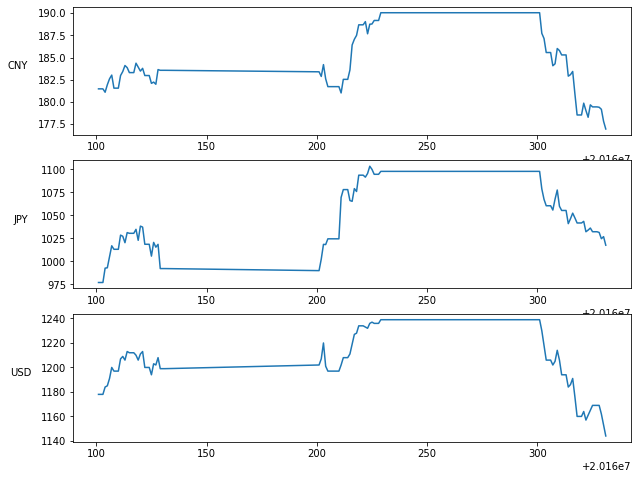

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ['CNY', 'JPY', 'USD']) :
    ax.plot('APPL_DATE', 'STD_RATE', data = df_raw[df_raw['CURRENCY'] == currency])
    ax.set_ylabel(currency, rotation = 0, labelpad = 20)

- 100 - 200 구간과 220 - 300 구간의 평균과 변동이 달라 정상성이 만족되지 않음 -> 차분 확인 필요

**데이터 분할 - 통화별 데이터 분할**

In [10]:
df_CNY = df_raw[df_raw['CURRENCY'] == 'CNY'].set_index('APPL_DATE')
df_CNY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_JPY = df_raw[df_raw['CURRENCY'] == 'JPY'].set_index('APPL_DATE')
df_JPY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_USD = df_raw[df_raw['CURRENCY'] == 'USD'].set_index('APPL_DATE')
df_USD.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

In [11]:
df_CNY.head()

,STD_RATE
APPL_DATE,
20160101,181.48
20160102,181.48
20160103,181.48
20160104,181.10
20160105,181.94


In [12]:
df_JPY.head()

,STD_RATE
APPL_DATE,
20160101,976.99
20160102,976.99
20160103,976.99
20160104,992.62
20160105,993.00


In [13]:
df_USD.head()

,STD_RATE
APPL_DATE,
20160101,1178.0
20160102,1178.0
20160103,1178.0
20160104,1184.0
20160105,1185.0


**데이터 분할 - train/test 데이터 분할**

In [15]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [18]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print('Shape of train data : {}'.format(df_CNY_train.shape))
print('Shape of test data : {}'.format(df_CNY_test.shape))

Shape of train data : (82, 1)
Shape of test data : (9, 1)


In [21]:
df_CNY

,STD_RATE
APPL_DATE,
20160101,181.48
20160102,181.48
20160103,181.48
20160104,181.10
20160105,181.94
...,...
20160327,179.45
20160328,179.41
20160329,179.18


In [26]:
# df_CNY_train = df_CNY[df_CNY.index <= '2016-03-22']
# df_CNY_test = df_CNY[df_CNY.index > '2016-03-22']

In [27]:
df_CNY_train = df_CNY[df_CNY.index <= 20160322]
df_CNY_test = df_CNY[df_CNY.index > 20160322]

In [28]:
df_CNY_train.head()

,STD_RATE
APPL_DATE,
20160101,181.48
20160102,181.48
20160103,181.48
20160104,181.10
20160105,181.94


In [29]:
df_CNY_test.head()

,STD_RATE
APPL_DATE,
20160323,178.28
20160324,179.68
20160325,179.45
20160326,179.45
20160327,179.45


**데이터 분할 - 차분을 통하여 정상성 데이터로 변환**

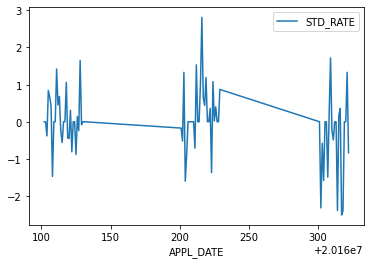

In [32]:
# 1차 차분
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

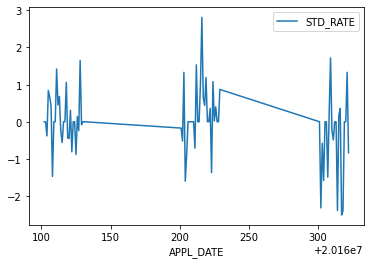